<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/13_ViT/CatsAndDogs_ViT/Cats_Dogs_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers with PyTorch

With the blog reference: [Cats&Dogs viT hands on blog](https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/), exploring the ViT code in PyTorch to train dogs and cats classification

[Dataset](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) We will be implementing the code for Vision Transformers with PyTorch using [vit_pytorch package](https://github.com/lucidrains/vit-pytorch) and  and Linformer 

In [1]:
pip install vit-pytorch linformer

**How it works** </br>
ViT breaks an input image of 16×16 to a  sequence of patches, just like a series of word embeddings generated by an NLP Transformers. Each patch gets flattened into a single vector in a series of interconnected channels of all pixels in a patch, then projects it to desired input dimension. Because transformers operate in self-attention mode, and they do not necessarily depend on the structure of the input elements, which in turns helps the architecture to learn and relate sparsely-distributed information more efficiently. In Vit, the relationship between the patches in an image is not known and thus allows it to learn more relevant features from the training data and encode in positional embedding in ViT. 

In [2]:
!pip install kaggle

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyakamat","key":"b0220a92ebcd97088f457500915cf150"}'}

## Loading Kaggle dataset:
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [13]:
!pwd

/content


In [14]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
! cp kaggle.json ~/.kaggle/

In [16]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 534M/544M [00:08<00:00, 69.1MB/s]
100% 544M/544M [00:08<00:00, 65.3MB/s]
 96% 260M/271M [00:03<00:00, 92.0MB/s]
100% 271M/271M [00:03<00:00, 88.6MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 111MB/s]


# Import libraries 

In [18]:
# loading Libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   


# import Linformer

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function
# import torch and related libraries 

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile   
#sklearn to split the data

from sklearn.model_selection import train_test_split  

In [21]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 
#Load data

os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

In [20]:
#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

In [22]:
#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [23]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

# Print few images 

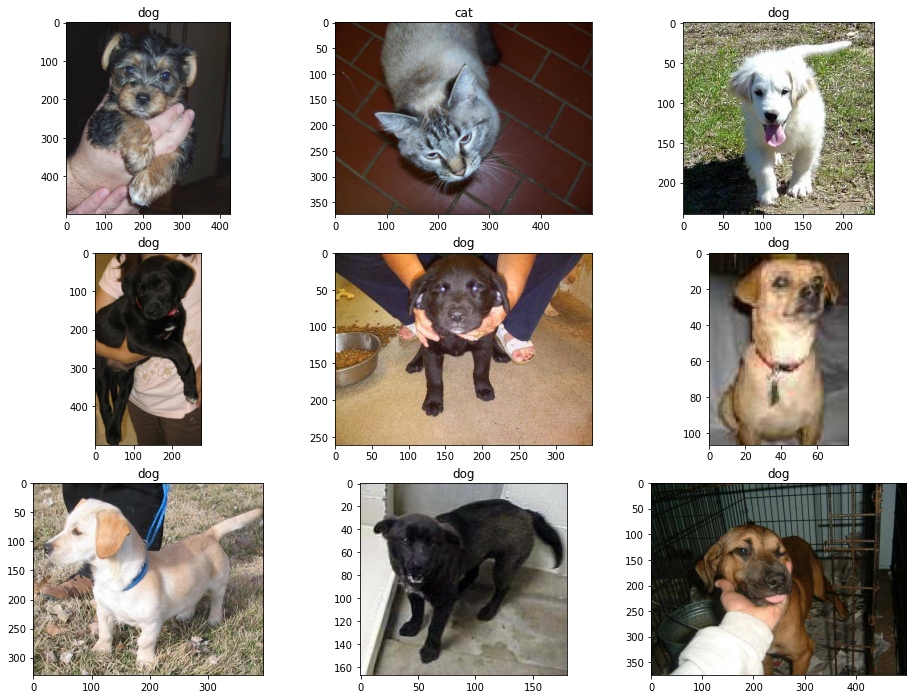

In [24]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [25]:
seed = 40

#Split train and validation list

In [26]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


# Transforms

In [27]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

#Load dataset for training 


In [28]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

# Load dataloader

In [29]:
#defining train, validation and test dataset
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

#Line transformer 


In [30]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#Visual transformer 


## Parameters

- dim: int. Last dimension of output tensor after linear transformation nn.Linear(..., dim).
- image_size: int. Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
- patch_size: int. Number of patches. image_size must be divisible by patch_size.
  The number of patches is: n = (image_size // patch_size) ** 2 and n must be greater than 16.
- num_classes: int. Number of classes to classify.
- depth: int. Number of Transformer blocks.
- heads: int. Number of heads in Multi-head Attention layer.
- channels: int, default 3. Number of image's channels.


In [32]:
#Visual transformer 
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

# Model

In [33]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [34]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# Training

In [35]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6955 - acc: 0.5061 - val_loss : 0.6910 - val_acc: 0.5303




Epoch : 2 - loss : 0.6914 - acc: 0.5242 - val_loss : 0.6870 - val_acc: 0.5492




Epoch : 3 - loss : 0.6843 - acc: 0.5520 - val_loss : 0.6774 - val_acc: 0.5722




Epoch : 4 - loss : 0.6779 - acc: 0.5726 - val_loss : 0.6693 - val_acc: 0.5890




Epoch : 5 - loss : 0.6710 - acc: 0.5811 - val_loss : 0.6818 - val_acc: 0.5680




Epoch : 6 - loss : 0.6611 - acc: 0.5938 - val_loss : 0.6538 - val_acc: 0.6106




Epoch : 7 - loss : 0.6539 - acc: 0.6010 - val_loss : 0.6544 - val_acc: 0.6082




Epoch : 8 - loss : 0.6485 - acc: 0.6092 - val_loss : 0.6447 - val_acc: 0.6210




Epoch : 9 - loss : 0.6423 - acc: 0.6218 - val_loss : 0.6424 - val_acc: 0.6238




Epoch : 10 - loss : 0.6367 - acc: 0.6266 - val_loss : 0.6338 - val_acc: 0.6329




Epoch : 11 - loss : 0.6337 - acc: 0.6266 - val_loss : 0.6354 - val_acc: 0.6341




Epoch : 12 - loss : 0.6284 - acc: 0.6400 - val_loss : 0.6252 - val_acc: 0.6537




Epoch : 13 - loss : 0.6198 - acc: 0.6461 - val_loss : 0.6176 - val_acc: 0.6509




Epoch : 14 - loss : 0.6157 - acc: 0.6469 - val_loss : 0.6153 - val_acc: 0.6655




Epoch : 15 - loss : 0.6086 - acc: 0.6601 - val_loss : 0.6102 - val_acc: 0.6602




Epoch : 16 - loss : 0.6091 - acc: 0.6602 - val_loss : 0.6043 - val_acc: 0.6697




Epoch : 17 - loss : 0.6030 - acc: 0.6634 - val_loss : 0.6195 - val_acc: 0.6513




Epoch : 18 - loss : 0.6010 - acc: 0.6653 - val_loss : 0.5974 - val_acc: 0.6770




Epoch : 19 - loss : 0.5989 - acc: 0.6699 - val_loss : 0.5992 - val_acc: 0.6727




Epoch : 20 - loss : 0.5967 - acc: 0.6711 - val_loss : 0.6024 - val_acc: 0.6707

